In [1]:
import autograd.numpy as np
import autograd.scipy as sp
from autograd.scipy import special
from autograd import grad, hessian, hessian_vector_product, hessian, jacobian
import matplotlib.pyplot as plt
%matplotlib inline  

from copy import deepcopy

from scipy import optimize

import time

import valez_finite_VI_lib as vi
from data_set_lib import DataSet
import generic_optimization_lib as packing

In [2]:
#np.random.seed(12321)

alpha = 10 # IBP parameter

num_samples = 50 # sample size
D = 2 # dimension

sigma_a = 3.0 ** 2

sigma_eps = 1.0 ** 2 # variance of noise

k_inf = 3 # take to be large for a good approximation to the IBP

pi, Z, mu, A, X = vi.generate_data(num_samples, D, k_inf, sigma_a, sigma_eps, alpha)

k_approx = k_inf # variational truncation

tau_init, nu_init, phi_mu_init, phi_var_init = \
    vi.initialize_parameters(num_samples, D, k_approx)

params_init = packing.pack_params(deepcopy(tau_init), deepcopy(phi_mu_init),
                                  deepcopy(phi_var_init), deepcopy(nu_init))

hyper_params = packing.pack_hyperparameters(alpha, sigma_a, sigma_eps)

data_set = DataSet(X, k_approx, alpha, sigma_eps, sigma_a)

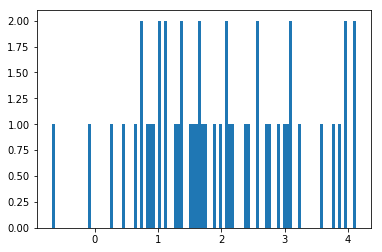

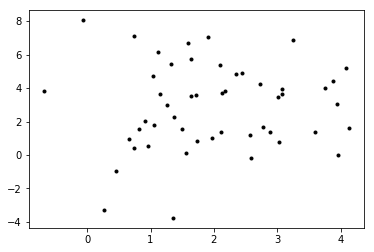

In [3]:
col = 0
plt.figure()
plt.hist(data_set.x[:, col], bins=100);

col1 = 0
col2 = 1
plt.figure()
plt.plot(data_set.x[:, col1], data_set.x[:, col2], 'k.');

In [4]:
# Parameters approximating the true distribution

tau_true = np.zeros_like(tau_init)
tau_true_scale = 15.
tau_true[:, 0] = deepcopy(pi) * tau_true_scale
tau_true[:, 1] = tau_true_scale

nu_true = np.zeros_like(nu_init)
nu_true[Z == 1] = 0.999
nu_true[Z == 0] = 0.001

phi_mu_true = np.zeros_like(phi_mu_init)
phi_mu_true[:] = A.transpose()
phi_var_true = np.zeros_like(phi_var_init)
phi_var_true[:] = 0.01

params_true = packing.pack_params(deepcopy(tau_true), deepcopy(phi_mu_true),
                                  deepcopy(phi_var_true), deepcopy(nu_true))

In [6]:
true_init = False
if true_init:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_true)
else:
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params_init)

tau, nu, phi_mu, phi_var = data_set.run_cavi(tau, nu, phi_mu, phi_var, max_iter=100, tol=1e-6)

cavi_tau = deepcopy(tau)
cavi_phi_mu = deepcopy(phi_mu)
cavi_phi_var = deepcopy(phi_var)
cavi_nu = deepcopy(nu)

Step 0 objective: 49.1320874167
Step 10 objective: 2.77921626973
Step 20 objective: 0.8376943671
Step 30 objective: 0.463518173291
Step 40 objective: 0.256116264118
Step 50 objective: 0.137266852515
Step 60 objective: 0.069974213592
Step 70 objective: 0.0390914049921
Step 80 objective: 0.0195600009225
Step 90 objective: 0.00958953111388
Done with CAVI.


In [7]:
# CAVI can return nu values that are too close to 0 or 1 for the encoding.
nu_tol = 1e-8
cavi_nu_trim = deepcopy(cavi_nu)
cavi_nu_trim[cavi_nu_trim < nu_tol] = nu_tol
cavi_nu_trim[cavi_nu_trim > 1 - nu_tol] = 1 - nu_tol

cavi_params = packing.pack_params(cavi_tau, cavi_phi_mu, cavi_phi_var, cavi_nu_trim)
print np.all(np.isfinite(cavi_params))

True


In [47]:
data_set.trace.reset()
vb_opt = data_set.run_newton_tr(cavi_params, maxiter=50, gtol=1e-2)
tr_params = deepcopy(vb_opt.x)
tr_tau, tr_phi_mu, tr_phi_var, tr_nu = data_set.unpack_params(tr_params)


Step 0 objective: -381.456805399
Optimization terminated successfully.
         Current function value: -381.462981
         Iterations: 4
         Function evaluations: 5
         Gradient evaluations: 5
         Hessian evaluations: 0
Done with Newton trust region.


In [40]:
print 'CAVI:'
print cavi_phi_mu.transpose()

print 'Full TR:'
tau, phi_mu, phi_var, nu = data_set.unpack_params(tr_params)
print phi_mu.transpose()

print 'Truth:'
print A

CAVI:
[[ 0.29254687  3.31695308]
 [ 1.076256    3.57609075]
 [ 0.97816469 -2.53189105]]
Full TR:
[[ 0.29515302  3.30011973]
 [ 1.0680591   3.63333428]
 [ 0.98232188 -2.58008701]]
Truth:
[[ 0.95078324 -2.80947271]
 [-0.01014661  4.00469059]
 [ 1.66152966  2.70338941]]


Cavi residuals: 69.4787422654    Trust residuals: 69.4542645747      True residuals: 71.724567008


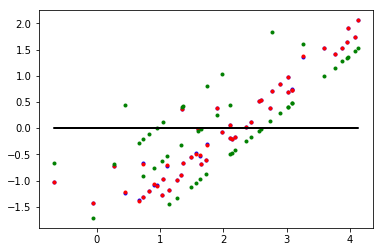

In [41]:
cavi_resid = data_set.x - data_set.get_prediction(cavi_params)
tr_resid = data_set.x - data_set.get_prediction(tr_params)
true_resid = data_set.x - np.matmul(Z, A)

plt.figure()
col = 0
plt.plot(data_set.x[:, col], tr_resid[:, col], '.b')
plt.plot(data_set.x[:, col], cavi_resid[:, col], '.r')
plt.plot(data_set.x[:, col], true_resid[:, col], '.g')
plt.plot(data_set.x[:, col], np.full_like(data_set.x[:, col], 0.), 'k')

print('Cavi residuals: {}    Trust residuals: {}      True residuals: {}'.format(
       np.sum(np.abs(cavi_resid)), np.sum(np.abs(tr_resid)), np.sum(np.abs(true_resid))))


In [42]:
def get_moments(params, data_set):
    # Return moments of interest.
    tau, phi_mu, phi_var, nu = data_set.unpack_params(params)
    e_log_pi, e_log_pi2, e_mu, phi_moment2, nu_moment = \
        vi.get_moments(tau, nu, phi_mu, phi_var)
    return e_log_pi, e_mu

def get_moments_vector(params, data_set):
    e_log_pi, e_mu = get_moments(params, data_set)
    return packing.pack_moments(e_log_pi, e_mu)

get_moments_vector_jac = jacobian(get_moments_vector)

jac_time = time.time()
moment_jac = get_moments_vector_jac(tr_params, data_set)
jac_time = time.time() - jac_time
print jac_time

par_hp_hess_time = time.time()
par_hp_hess = data_set.get_kl_sens_hess(tr_params, hyper_params)
par_hp_hess_time = time.time() - par_hp_hess_time


0.00434994697571


In [62]:
hess_time = time.time()
kl_hess = data_set.get_kl_hessian(tr_params)
hess_time = time.time() - hess_time
kl_hess_eigvals = np.linalg.eigvals(kl_hess)
print hess_time

0.832869052887


In [64]:
print np.max(kl_hess_eigvals)
print np.min(kl_hess_eigvals)

101.285003908
2.01047967281e-07


In [69]:
# Eq. 18 from our paper.  The -1 comes from the fact that par_hp_hess is of the
# KL divergence, not the expected log probability.
sensitivity_operator = -1 * np.linalg.solve(kl_hess, par_hp_hess.T)
moment_sensitivity = np.matmul(moment_jac, sensitivity_operator)

print(moment_sensitivity)

[[  5.76256154e-03   1.13918377e-04  -4.23115500e-02]
 [  6.43866162e-04   1.56657886e-04   6.91675137e-03]
 [  1.57798013e-03   8.95386206e-04   1.01487632e-01]
 [ -1.65728868e-04  -1.77194251e-04  -1.67319565e-01]
 [ -1.77316419e-03  -1.80262452e-03  -2.06353473e-01]
 [  1.10302745e-03   1.17385581e-03   2.16292286e-01]
 [  8.19270205e-04  -6.00435477e-04   3.38613418e-01]
 [  4.35782180e-03   2.13630292e-02  -2.61062053e-01]
 [ -5.36677868e-03  -2.05734723e-02   4.33513180e-01]]


In [68]:
# The third column is sigma_eps.

sigma_eps_col = 2
e_log_pi_sigma_eps_sens, e_mu_sigma_eps_sens = \
    packing.unpack_moments(moment_sensitivity[:, sigma_eps_col], k_approx, D)
    
print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

Sensitivity of e_log_pi to sigma_eps:
[ 0.04231155 -0.00691675 -0.10148763]
Sensitivity of e_mu to sigma_eps:
[[ 0.16731957  0.20635347 -0.21629229]
 [-0.33861342  0.26106205 -0.43351318]]


In [58]:
# Perturb and re-rerun to check the sensitivity.

epsilon = 1e-1
data_set_perturb = DataSet(X, k_approx, alpha, sigma_eps + epsilon, sigma_a)
data_set_perturb.trace.print_every = 1
vb_opt_perturb = data_set_perturb.run_newton_tr(tr_params)

Step 0 objective: -340.621482663
Step 1 objective: -340.695193097
Step 2 objective: -340.697977272
Step 3 objective: -340.722193526
Step 4 objective: -340.732786709
Step 5 objective: -340.735777414
Step 6 objective: -340.73962136
Step 7 objective: -340.741611071
Step 8 objective: -340.743190434
Step 9 objective: -340.744021389
Step 10 objective: -340.74419111
Step 11 objective: -340.744414823
Step 12 objective: -340.744377162
Step 13 objective: -340.744443481
Step 14 objective: -340.744441697
Step 15 objective: -340.74444676
Step 16 objective: -340.744447384
Step 17 objective: -340.744448151
Step 18 objective: -340.744448075
Step 19 objective: -340.744448263
Step 20 objective: -340.744448364
Step 21 objective: -340.744448404
Step 22 objective: -340.744448408
Optimization terminated successfully.
         Current function value: -340.744448
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 20
         Hessian evaluations: 0
Done with Newton trust r

In [65]:
e_log_pi, e_mu = get_moments(tr_params, data_set)
e_log_pi_perturb, e_mu_perturb = get_moments(vb_opt_perturb.x, data_set)

print('Measured sensitivity of e_mu to sigma_eps:')
print((e_mu_perturb - e_mu) / epsilon)

print('Sensitivity of e_mu to sigma_eps:')
print(e_mu_sigma_eps_sens)

print('Measured sensitivity of e_log_pi to sigma_eps:')
print((e_log_pi_perturb - e_log_pi) / epsilon)

print('Sensitivity of e_log_pi to sigma_eps:')
print(e_log_pi_sigma_eps_sens)

Measured sensitivity of e_mu to sigma_eps:
[[-0.20500243 -0.15441005  0.18285128]
 [ 0.36771794 -0.51133938  0.69617675]]
Sensitivity of e_mu to sigma_eps:
[[ 0.16731957  0.20635347 -0.21629229]
 [-0.33861342  0.26106205 -0.43351318]]
Measured sensitivity of e_log_pi to sigma_eps:
[-0.05244449  0.00724903  0.09950279]
Sensitivity of e_log_pi to sigma_eps:
[ 0.04231155 -0.00691675 -0.10148763]
